# Abnormal Returns

In [1]:
NAME = '05-01_abnormal_returns'
PROJECT = 'conference-calls-sentiment'
PYTHON_VERSION = '3.7.0'

### Imports

In [2]:
import os
import re
import numpy as np
import pandas as pd

### Settings

In [3]:
workdir = re.sub("(?<={})[\w\W]*".format(PROJECT), "", os.getcwd())
os.chdir(workdir)

pipeline = os.path.join('2_pipeline', NAME)
if not os.path.exists(pipeline):
    os.makedirs(pipeline)
    for folder in ['out', 'store', 'tmp']:
        os.makedirs(os.path.join(pipeline, folder))

---
# Main Code
*Data source: WRDS Event Study (CRSP)*

## Save Events

In [4]:
cc = pd.read_feather(os.path.join('2_pipeline', '02-02_conference_calls_preprocess', 'out', 'cc_transcripts.feather'))

In [5]:
cc[['ticker', 'event_date']].drop_duplicates().to_csv(os.path.join(pipeline, 'store', 'events'), sep=' ', header=False, index=False)

## Process Event Study Data

In [4]:
def read_event_study(filepath):
    event_study = pd.read_csv(filepath)
    columns = event_study.columns[0].split()
    event_study[columns] = event_study.iloc[:, 0].str.split(expand=True)

    event_study_clean = (event_study
                         .assign(ret=pd.to_numeric(event_study['ret'], errors='coerce'),
                                 abret=pd.to_numeric(event_study['abret'], errors='coerce'),
                                 evttime=pd.to_numeric(event_study['evttime'], errors='coerce'))
                         .dropna(subset=['ret', 'abret', 'evttime'])
                         .assign(evtdate=lambda x: pd.to_datetime(x['evtdate'], format=r'%d%b%Y'),
                                 car=lambda x: x.groupby(['ticker', 'evtdate'])['abret'].cumsum())
                         .filter(['ticker', 'evtdate', 'evttime', 'ret', 'abret', 'car'])
                         .rename(columns={'evtdate': 'event_date', 'evttime': 'day', 'abret': 'ar'})
                         .reset_index(drop=True))
    return event_study_clean

In [ ]:
event_study_path = os.path.join('0_data', 'event_study', 'minus_10_to_60_daily.txt')
event_study = read_event_study(event_study_path)
event_study.head()

In [9]:
event_study.to_feather(os.path.join(pipeline, 'out', 'event_study.feather'))

In [6]:
def period_ret(start, end):
    return (event_study
            .loc[event_study['day'].between(start, end)]
            .groupby(['ticker', 'event_date'])['ret'].sum() * 100)

def period_car(start, end):
    return (event_study
            .loc[event_study['day'].between(start, end)]
            .groupby(['ticker', 'event_date'])['ar'].sum() * 100)

In [ ]:
car = (event_study
       .copy()
       .filter(['ticker', 'event_date'])
       .drop_duplicates()
       .set_index(['ticker', 'event_date'])
       .assign(car_st=period_car(-1, 1),
               car_drift=period_car(2, 60),
               ret_trade=period_ret(1, 1))
       .sort_index()
       .reset_index())
                  
car.head()

In [10]:
car.to_feather(os.path.join(pipeline, 'out', 'abnormal_returns.feather'))

---
# Analysis

In [16]:
import matplotlib.pyplot as plt
import paper_style

In [17]:
event_study.query('day == 1')['ret'].mean()

0.00019494321527719353

<AxesSubplot:xlabel='day'>

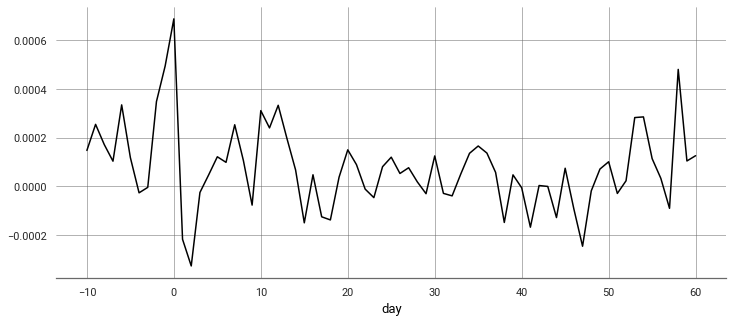

In [18]:
event_study.groupby('day')['ar'].mean().plot()

<AxesSubplot:xlabel='day'>

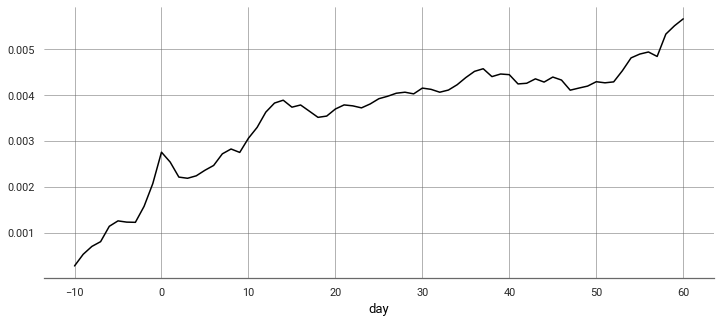

In [19]:
event_study.groupby('day')['car'].mean().plot()